In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
%load_ext line_profiler
%load_ext memory_profiler

### code profiling help

https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html

`%time`: Time the execution of a single statement  
`%timeit`: Time repeated execution of a single statement for more accuracy  
`%prun`: Run code with the profiler  
`%lprun`: Run code with the line-by-line profiler  
`%memit`: Measure the memory use of a single statement  
`%mprun`: Run code with the line-by-line memory profiler  


# pantograph_constructor

> This package provides all functionality from graph construction (currently, from annotation, in the future, from raw assembled sequences) to graph processing (sorting, grouping, adjusting). 

>It also provides universal graph data model class `GenomeGraph`, which implements graph IO through GFA v1 (in the future also v2 format) as well as all operations on the graph.

## Install

Enter the directory of the library and enter:

`pip install .`

## How to use

In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_init.ipynb.
Converted 01_graph.ipynb.
Converted 02_tree.ipynb.
Converted 03_synteny.ipynb.
Converted 04_utils.ipynb.
Converted 05_export.ipynb.
Converted deBruijnGraphProcessing.ipynb.
Converted graphTesting.ipynb.
Converted index.ipynb.


In [ ]:
from redis import Redis

In [ ]:
import cProfile
import pstats
from pstats import SortKey

In [ ]:
import os
import glob
import re
from random import shuffle

import networkx as nx

from pangraph_constructor.graph import GenomeGraph
from pangraph_constructor.synteny import generateOrder,readTransMap
from pangraph_constructor.tree import TremauxTree
from pangraph_constructor.utils import pathFileToPathDict,getDBID
from pangraph_constructor.utils import iset_add,iset_score

In [ ]:
from pangraph_constructor.utils import adjustZoomLevels,pathConvert
from pangraph_constructor.export import exportToPantograph

In [ ]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
datadir = '../../1001G/annotations/freeze2.1'
gfadir = '../../1001G/pantograph/data'

In [ ]:
datadir = '.'
gfadir = '.'

In [ ]:
annotationFiles = sorted(glob.glob(f'{datadir}{os.path.sep}*.gff'))
sequenceFiles = sorted(glob.glob(f'{datadir}{os.path.sep}sequences{os.path.sep}*.fasta'))
transMapFile = f'{datadir}{os.path.sep}TransMap{os.path.sep}TransMap.map'
refAnnotationFile = f'{datadir}{os.path.sep}outgroups/araport.gff'
refSequenceFile = f'{datadir}{os.path.sep}outgroups/araport.fasta'

In [ ]:
refAnnotationFile,refSequenceFile,annotationFiles,sequenceFiles,transMapFile

('../../1001G/annotations/freeze2.1/outgroups/araport.gff',
 '../../1001G/annotations/freeze2.1/outgroups/araport.fasta',
 ['../../1001G/annotations/freeze2.1/10002.gff',
  '../../1001G/annotations/freeze2.1/10015.gff',
  '../../1001G/annotations/freeze2.1/10024.gff',
  '../../1001G/annotations/freeze2.1/1741.gff',
  '../../1001G/annotations/freeze2.1/22001.gff',
  '../../1001G/annotations/freeze2.1/22002.gff',
  '../../1001G/annotations/freeze2.1/22003.gff',
  '../../1001G/annotations/freeze2.1/22004.gff',
  '../../1001G/annotations/freeze2.1/22005.gff',
  '../../1001G/annotations/freeze2.1/22006.gff',
  '../../1001G/annotations/freeze2.1/22007.gff',
  '../../1001G/annotations/freeze2.1/6024.gff',
  '../../1001G/annotations/freeze2.1/6069.gff',
  '../../1001G/annotations/freeze2.1/6124.gff',
  '../../1001G/annotations/freeze2.1/6244.gff',
  '../../1001G/annotations/freeze2.1/6909.gff',
  '../../1001G/annotations/freeze2.1/6966.gff',
  '../../1001G/annotations/freeze2.1/8236.gff',
  '.

In [ ]:
ATmap = readTransMap(transMapFile)

In [ ]:
fileOrder = generateOrder(annotationFiles,priorityAccession=None)
fileOrder

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26]

In [ ]:
# doCigars = False
doUS = False
gfaFilename = 'AT_Chr1_OGOnly_2.1.gfa'
seqSuffix = '_Chr1'

In [ ]:
notebook2script()

Converted 00_init.ipynb.
Converted 01_graph.ipynb.
Converted 02_tree.ipynb.
Converted 03_synteny.ipynb.
Converted 04_utils.ipynb.
Converted 05_export.ipynb.
Converted deBruijnGraphProcessing.ipynb.
Converted graphTesting.ipynb.
Converted index.ipynb.


In [ ]:
graph = GenomeGraph(annotationFiles=annotationFiles,
                    sequenceFiles=None,
                    fileOrder=fileOrder,
                    doUS=doUS,
                    seqSuffix=seqSuffix,
#                     refAnnotationFile=refAnnotationFile,
#                     refAccession='TAIR10',
                    transMap=ATmap)

Calculating nodes length...
Processing node 7125/7125
Finished calculating nodes lengths
Preprocessing paths...
Processing path 27/27
Finished preprocessing paths
Node 2 inverted
Node 3 inverted
Node 5 inverted
Node 6 inverted
Node 7 inverted
Node 8 inverted
Node 9 inverted
Node 10 inverted
Node 12 inverted
Node 13 inverted
Node 14 inverted
Node 15 inverted
Node 17 inverted
Node 19 inverted
Node 20 inverted
Node 26 inverted
Node 32 inverted
Node 33 inverted
Node 38 inverted
Node 39 inverted
Node 41 inverted
Node 42 inverted
Node 44 inverted
Node 46 inverted
Node 48 inverted
Node 52 inverted
Node 60 inverted
Node 61 inverted
Node 63 inverted
Node 64 inverted
Node 65 inverted
Node 66 inverted
Node 67 inverted
Node 70 inverted
Node 75 inverted
Node 77 inverted
Node 83 inverted
Node 84 inverted
Node 86 inverted
Node 87 inverted
Node 89 inverted
Node 91 inverted
Node 94 inverted
Node 97 inverted
Node 100 inverted
Node 101 inverted
Node 102 inverted
Node 103 inverted
Node 105 inverted
Node 1

In [ ]:
print(f'{gfadir}{os.path.sep}{gfaFilename}')

../../1001G/pantograph/data/AT_Chr1_OGOnly_2.1_noRef.gfa


In [ ]:
graph.toGFA(f'{gfadir}{os.path.sep}{gfaFilename}',doSeq=False)

In [ ]:
!ntfy send "Generating gene graph finished!"

# Loading graph from GFA

## Large graph

In [ ]:
notebook2script()

Converted 00_init.ipynb.
Converted 01_graph.ipynb.
Converted 02_tree.ipynb.
Converted 03_synteny.ipynb.
Converted 04_utils.ipynb.
Converted 05_export.ipynb.
Converted deBruijnGraphProcessing.ipynb.
Converted graphTesting.ipynb.
Converted index.ipynb.


In [ ]:
f'{gfadir}{os.path.sep}{gfaFilename}'

'../../1001G/pantograph/data/AT_Chr1_OGOnly_2.1_noRef.gfa'

In [ ]:
graph_new = GenomeGraph(gfaPath=f'{gfadir}{os.path.sep}{gfaFilename}',isGFASeq=False)

Loading graph from ../../1001G/pantograph/data/AT_Chr1_OGOnly_2.1_noRef.gfa
Found node annotation file ../../1001G/pantograph/data/annotation_AT_Chr1_OGOnly_2.1_noRef.dat, loading associations.
Loading segment 7125/7125
Loading segments finished.
Loading link 13059/13059
Loading links finished
Loading path 27/27
Loading paths finished. 27 paths added, 0 paths ignored.
Calculating nodes length...
Processing node 7125/7125
Finished calculating nodes lengths
Preprocessing paths...
Processing path 27/27
Finished preprocessing paths


In [ ]:
graph_new.treeSort()

Constructing Tremaux tree
Node: 2589
Graph edges: [(13, 2589), (404, 2589), (466, 2589), (1014, 2589), (1147, 2589), (1506, 2589), (1529, 2589), (1807, 2589), (2049, 2589), (2066, 2589), (2130, 2589), (2252, 2589), (2318, 2589), (2415, 2589), (2588, 2589), (2699, 2589), (2742, 2589), (2796, 2589), (2831, 2589), (2872, 2589), (2961, 2589), (2972, 2589), (3001, 2589), (3012, 2589), (3026, 2589), (3043, 2589), (3071, 2589), (3079, 2589), (3080, 2589), (3081, 2589), (3096, 2589), (3097, 2589), (3100, 2589), (3117, 2589), (3121, 2589), (3175, 2589), (3179, 2589), (3208, 2589), (3275, 2589), (3324, 2589), (3381, 2589), (3382, 2589), (3560, 2589), (3589, 2589), (3689, 2589), (4116, 2589), (4142, 2589), (4173, 2589), (4345, 2589), (4361, 2589), (4466, 2589), (4585, 2589), (4631, 2589), (4706, 2589), (4745, 2589), (5014, 2589), (5080, 2589), (5400, 2589), (5615, 2589), (5651, 2589), (5652, 2589), (6158, 2589), (6376, 2589), (6382, 2589), (6516, 2589), (6539, 2589), (7027, 2589), (7114, 2589)]
T

In [ ]:
assert len(graph_new.nodes)==len(graph_new.order)

In [ ]:
len(graph_new.order),len(graph_new.nodes),len(graph_new.tremauxTree),len(graph_new.tremauxTree.originalGraph)

(7125, 7125, 7125, 7125)

In [ ]:
gfaFilename

'AT_Chr1_OGOnly_2.1_noRef.gfa'

In [ ]:
gfadir

'../../1001G/pantograph/data'

In [ ]:
graph_new.toGFA(f'{gfadir}{os.path.sep}{gfaFilename}',doSeq=False)

In [ ]:
!ntfy send "Sorting gene graph finished!"

## Large graph with unrelated sequences and real sequences

In [ ]:
graph_new2 = GenomeGraph(gfaPath='./test_long_graph_full_seq.gfa',isGFASeq=True)

In [ ]:
len(graph_new2.accessions)

27

In [ ]:
graph_new2.treeSort()

Constructing Tremaux tree
Done!
Getting root nodes
Start Loop...
0 - 0 - 1 - 1 - 2
0 - 1 - 2 - 2 - 3
1 - 2 - 3 - 3 - 4
1 - 2 - 3 - 3 - 7824
0 - 3 - 4 - 3 - 4
0 - 4 - 5 - 4 - 5
0 - 5 - 6 - 5 - 6
1 - 6 - 7 - 6 - 7
1 - 7 - 8 - 7 - 8
1 - 8 - 9 - 8 - 9
1 - 9 - 10 - 9 - 10
1 - 10 - 11 - 10 - 11
1 - 11 - 12 - 11 - 12
1 - 12 - 13 - 12 - 13
2 - 13 - 14 - 13 - 14
3 - 14 - 15 - 14 - 16
3 - 14 - 15 - 14 - 15
2 - 15 - 16 - 14 - 16
2 - 16 - 17 - 16 - 17
2 - 17 - 18 - 17 - 18
2 - 18 - 19 - 18 - 19
2 - 19 - 20 - 19 - 20
2 - 20 - 21 - 20 - 21
2 - 21 - 22 - 21 - 22
2 - 22 - 23 - 22 - 23
2 - 23 - 24 - 23 - 24
2 - 24 - 25 - 24 - 25
2 - 25 - 26 - 25 - 26
2 - 26 - 27 - 26 - 27
2 - 27 - 28 - 27 - 28
2 - 28 - 29 - 28 - 29
2 - 29 - 30 - 29 - 30
2 - 30 - 31 - 30 - 31
3 - 31 - 32 - 31 - 32
3 - 32 - 33 - 32 - 33
3 - 32 - 33 - 31 - 7868
2 - 33 - 34 - 32 - 33
2 - 34 - 35 - 33 - 34
2 - 35 - 36 - 34 - 35
3 - 36 - 37 - 35 - 36
3 - 37 - 38 - 36 - 37
3 - 37 - 38 - 35 - 6862
3 - 38 - 39 - 6862 - 6863
2 - 39 - 40 - 36 - 3

In [ ]:
len(graph_new2.order),len(graph_new2.nodes),len(graph_new2.tremauxTree),len(graph_new2.tremauxTree.originalGraph)

(8087, 8087, 8087, 8087)

In [ ]:
gfaFilename

'AT_Chr1_Full_Seq.gfa'

In [ ]:
gfadir

'../../1001G/pantograph/data'

In [ ]:
gfaFilename = 'AT_Chr1_OGOnly_Seq.gfa'

In [ ]:
graph_new2.toGFA(f'{gfadir}{os.path.sep}{gfaFilename}',doSeq=True)

## Christian's test graph

In [ ]:
graph_new = GenomeGraph(gfaPath='../../1001G/graphSorting/graphs/sixRef.panGenome.Chroms.pggb.Chr2.5mb.gfa',isGFASeq=True)

In [ ]:
len(graph_new.accessions)

7

In [ ]:
cProfile.run('graph_new.treeSort()','treesort_profile')

Constructing Tremaux tree
Done!
Getting root nodes
Start Loop...
0 - 0 - 1 - 1 - 2
0 - 1 - 2 - 2 - 3
0 - 2 - 3 - 3 - 4
0 - 3 - 4 - 4 - 5
0 - 4 - 5 - 5 - 6
0 - 5 - 6 - 6 - 7
0 - 6 - 7 - 7 - 8
0 - 7 - 8 - 8 - 9
0 - 8 - 9 - 9 - 10
0 - 9 - 10 - 10 - 11
0 - 10 - 11 - 11 - 12
0 - 11 - 12 - 12 - 13
0 - 12 - 13 - 13 - 14
0 - 13 - 14 - 14 - 15
0 - 14 - 15 - 15 - 16
0 - 15 - 16 - 16 - 17
0 - 16 - 17 - 17 - 18
0 - 17 - 18 - 18 - 19
0 - 18 - 19 - 19 - 20
0 - 19 - 20 - 20 - 21
0 - 20 - 21 - 21 - 22
0 - 21 - 22 - 22 - 23
0 - 22 - 23 - 23 - 24
0 - 23 - 24 - 24 - 25
0 - 24 - 25 - 25 - 26
0 - 25 - 26 - 26 - 27
0 - 26 - 27 - 27 - 28
0 - 27 - 28 - 28 - 29
0 - 28 - 29 - 29 - 30
0 - 29 - 30 - 30 - 31
0 - 30 - 31 - 31 - 32
0 - 31 - 32 - 32 - 33
0 - 32 - 33 - 33 - 34
0 - 33 - 34 - 34 - 35
0 - 34 - 35 - 35 - 36
0 - 35 - 36 - 36 - 37
0 - 36 - 37 - 37 - 38
0 - 37 - 38 - 38 - 39
0 - 38 - 39 - 39 - 40
0 - 39 - 40 - 40 - 41
0 - 40 - 41 - 41 - 42
0 - 41 - 42 - 42 - 43
0 - 42 - 43 - 43 - 44
0 - 43 - 44 - 44 - 45
0 -

In [ ]:
p = pstats.Stats('treesort_profile')
p.strip_dirs().sort_stats(SortKey.CUMULATIVE).print_stats()

In [ ]:
len(graph_new.order),len(graph_new.nodes),len(graph_new.tremauxTree),len(graph_new.tremauxTree.originalGraph)

(447, 447, 447, 447)

In [ ]:
gfaFilename='testChristian_new.gfa'

In [ ]:
gfadir

'../../1001G/pantograph/data'

In [ ]:
graph_new.toGFA(f'{gfadir}{os.path.sep}{gfaFilename}',doSeq=True)

In [ ]:
shuffle(graph_new.order)

In [ ]:
gfaFilename='testChristian_shuffled.gfa'

In [ ]:
graph_new = GenomeGraph(gfaPath='../../1001G/pantograph/data/testChristian_shuffled.gfa',isGFASeq=True)

## Loading Pathfile to graph

In [ ]:
pathfileDir = '../../1001G/coreGraph'
pathsfile = 'paths_v3.txt'
# pathsfile = 'paths.txt'

paths = pathFileToPathDict(f'{pathfileDir}{os.path.sep}{pathsfile}',True)

In [ ]:
coregraph = GenomeGraph(pathsDict=paths)

Calculating nodes length...
Processing node 38/38
Finished calculating nodes lengths
Preprocessing paths...
Processing path 27/27
Finished preprocessing paths


In [ ]:
coregraph.treeSort()

Constructing Tremaux tree
Node: 26
Graph edges: [(13, 26), (24, 26), (25, 26)]
Tree edges: [(13, 26)]
Edge to keep: (24, 26)
Cycle found!
Path to break: [26, 25, 24]
Unbreakable path!
Node: 22
Graph edges: [(13, 22), (21, 22), (23, 22)]
Tree edges: [(23, 22)]
Edge to keep: (21, 22)
Cycle found!
Path to break: [22, 21]
Unbreakable path!
Node: 23
Graph edges: [(21, 23), (22, 23), (24, 23)]
Tree edges: [(24, 23)]
Edge to keep: (22, 23)
Cycle found!
Path to break: [23, 22]
Edge substituted!
Edge (21, 22) substitute edge (23, 22)
Done!
Getting root nodes
Start Loop...
0 - 0 - 1 - 1 - 2
0 - 1 - 2 - 2 - 3
0 - 2 - 3 - 3 - 4
0 - 3 - 4 - 4 - 5
0 - 4 - 5 - 5 - 6
0 - 5 - 6 - 6 - 7
0 - 6 - 7 - 7 - 8
0 - 7 - 8 - 8 - 9
0 - 8 - 9 - 9 - 10
0 - 9 - 10 - 10 - 11
0 - 10 - 11 - 11 - 12
0 - 11 - 12 - 12 - 13
0 - 12 - 13 - 13 - 14
0 - 13 - 14 - 14 - 15
0 - 14 - 15 - 15 - 16
0 - 15 - 16 - 16 - 17
0 - 16 - 17 - 17 - 18
0 - 17 - 18 - 18 - 19
0 - 18 - 19 - 19 - 20
0 - 19 - 20 - 20 - 21
0 - 20 - 21 - 21 - 22
0 - 

In [ ]:
len(coregraph.nodes),len(coregraph.order)

(38, 38)

In [ ]:
coreGFApath = f'{pathfileDir}{os.path.sep}coreGraph_v3.gfa'

In [ ]:
coregraph.toGFA(coreGFApath,False)

## Small simple graph

In [ ]:
graph2 = GenomeGraph(gfaPath='./shorttest.gfa',isGFASeq=False)

In [ ]:
graph2.forwardLinks

{1: {'+': [(3, '+')]},
 3: {'+': [(4, '+')], '-': [(6, '+')]},
 4: {'+': [(5, '+'), (9, '+')]},
 5: {'+': [(6, '+')]},
 6: {'+': [(4, '+'), (7, '+')]},
 7: {'+': [(8, '+')]},
 2: {'+': [(3, '-')]}}

In [ ]:
graph2.treeSort()

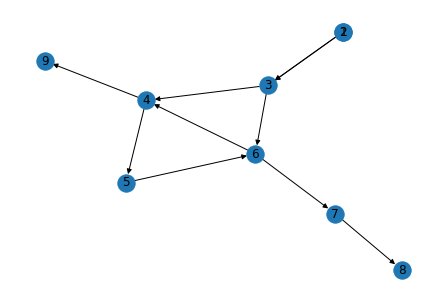

In [ ]:
graph2.tremauxTree.draw_original()

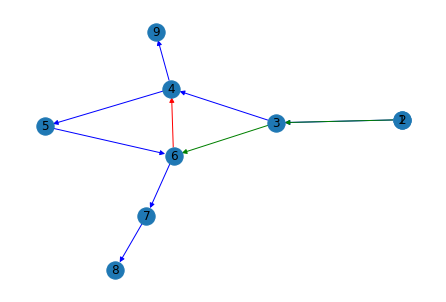

In [ ]:
graph2.tremauxTree.draw()

In [ ]:
graph2.order

[1, 3, 4, 5, 6, 7, 8, 9, 2]

In [ ]:
graph2.toGFA('../../1001G/pantograph/data/shorttest1.gfa',doSeq=False)

## Small graph with complex loops

In [ ]:
graph3 = GenomeGraph(gfaPath='./shorttest2.gfa',isGFASeq=False)

Loading graph from ./shorttest2.gfa
Loading segment 7/7
Loading segments finished.
Loading link 9/9
Loading links finished
Loading link 5/5
Loading paths finished. 5 paths added, 0 paths ignored.


In [ ]:
graph3.paths

[['2+', '4+', '7+', '1+'],
 ['2+', '3+', '5+', '6+', '2+'],
 ['1+', '2+', '4+', '7+'],
 ['4+', '7+', '1+', '2+', '3+', '5+'],
 ['5+', '6+', '2+', '4+', '7+']]

In [ ]:
graph3.treeSort()

Constructing Tremaux tree
Done!
Getting root nodes
Start Loop...
1 - 0 - 1 - 2 - 4
1 - 1 - 2 - 4 - 7
1 - 2 - 3 - 7 - 1
0 - 3 - 4 - 2 - 3
0 - 4 - 5 - 3 - 5
0 - 5 - 6 - 5 - 6


In [ ]:
pdb.pm()

> /usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py(44)_wrapit()
     42     except AttributeError:
     43         wrap = None
---> 44     result = getattr(asarray(obj), method)(*args, **kwds)
     45     if wrap:
     46         if not isinstance(result, mu.ndarray):



ipdb>  u


> /usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py(55)_wrapfunc()
     53     bound = getattr(obj, method, None)
     54     if bound is None:
---> 55         return _wrapit(obj, method, *args, **kwds)
     56 
     57     try:



ipdb>  u


> /usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py(1193)argmax()
   1191 
   1192     """
-> 1193     return _wrapfunc(a, 'argmax', axis=axis, out=out)
   1194 
   1195 



ipdb>  u


> <__array_function__ internals>(5)argmax()



ipdb>  u


> /data/YandexDisk/Kew/src/graphConstruction/pangraph_constructor/tree.py(110)_preprocessPathTree()
    108                 edgePaths = [self.parentGraph.edgePaths.get(edge,0) for edge in graphInEdgeList]
    109                 # Find the edge with maximum number of paths passing
--> 110                 edgeToKeep = graphInEdgeList[np.argmax(edgePaths)]
    111 #                 print(f'Edge to keep: {edgeToKeep}')
    112                 # If the best edge not in the tree already



ipdb>  edgePaths


[]


ipdb>  graphInEdgeList


[]


ipdb>  l94


*** NameError: name 'l94' is not defined


ipdb>  l 94


     89 
     90         return treeCombined
     91 
     92     def _preprocessPathTree(self,treeCombined):
     93 #         pdb.set_trace()
     94         for node in self.originalGraph.nodes:
     95 
     96             # get all edges coming to given node in the full graph
     97             graphInEdgeList = list(self.originalGraph.in_edges(node))
     98             # get all edges coming to a given node in the tremaux tree
     99             treeInEdgeList = list(treeCombined.in_edges(node))



ipdb>  node


2


ipdb>  self.originalGraph.in_edges


InEdgeView([(7, 1), (1, 2), (6, 2), (2, 3), (2, 4), (3, 5), (4, 6), (5, 6), (4, 7)])


ipdb>  self.originalGraph.in_edges(2)


InEdgeDataView([(1, 2), (6, 2)])


ipdb>  treeInEdgeList


[]


ipdb>  l 100


     95 
     96             # get all edges coming to given node in the full graph
     97             graphInEdgeList = list(self.originalGraph.in_edges(node))
     98             # get all edges coming to a given node in the tremaux tree
     99             treeInEdgeList = list(treeCombined.in_edges(node))
    100 #             print(f'Node: {node}')
    101 #             print(f'Graph edges: {graphInEdgeList}')
    102 #             print(f'Tree edges: {treeInEdgeList}')
    103             if len(graphInEdgeList)>0:# and len(treeInEdgeList)>0:
    104                 # Remove self-cycle paths larger cycles will be removed later.
    105                 graphInEdgeList = [edge for edge in graphInEdgeList if (not nx.has_path(treeCombined,edge[1],edge[0]) or (edge[::-1]) in treeCombined.edges) and edge[0]!=edge[1]] # removed 'not nx.has_path(treeCombined,edge[1],edge[0]) and '



ipdb>  nx.has_path(treeCombined,2,1)


True


ipdb>  nx.has_path(treeCombined,6,2)


False


ipdb>  nx.has_path(treeCombined,2,6)


True


ipdb>  (2,1) in treeCombined.edges


False


ipdb>  (2,6) in treeCombined.edges


False


ipdb>  q


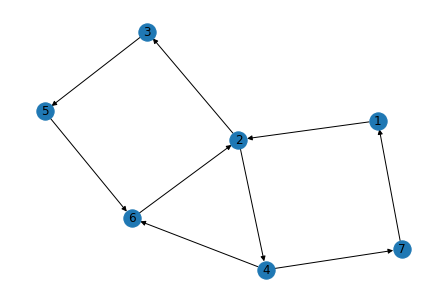

In [ ]:
graph3.tremauxTree.draw_original()

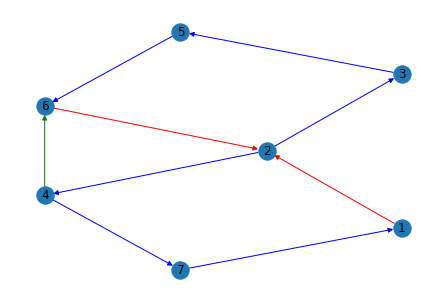

In [ ]:
graph3.tremauxTree.draw()

In [ ]:
len(graph3.order),len(graph3.nodes)

(7, 7)

In [ ]:
graph3.toGFA('../../1001G/pantograph/data/shorttest2.gfa',doSeq=False)

## Small graph with very complex relationships

In [ ]:
graph4 = GenomeGraph(gfaPath='./shorttest3.gfa',isGFASeq=False)

In [ ]:
graph4.paths

[['1+', '2+', '7+', '3+', '4+', '5+', '6+'],
 ['1+', '7+', '2+', '3+', '4+', '5+', '6+'],
 ['1+', '2+', '3+', '7+', '4+', '5+', '6+'],
 ['1+', '3+', '2+', '7+', '4+', '5+', '6+'],
 ['1+', '4+', '5+', '6+', '7+', '3+', '2+'],
 ['1+', '2+', '3+', '4+', '5+', '7+', '6+']]

In [ ]:
graph4.treeSort()

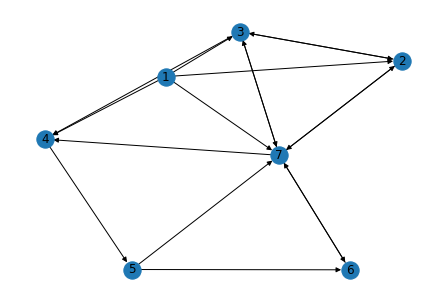

In [ ]:
graph4.tremauxTree.draw_original()

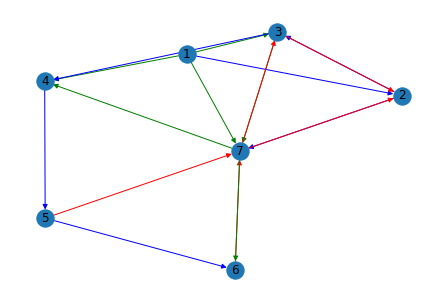

In [ ]:
graph4.tremauxTree.draw()

In [ ]:
graph4.order

[1, 2, 3, 4, 5, 6, 7]

In [ ]:
graph4.toGFA('../../1001G/pantograph/data/shorttest3.gfa',doSeq=False)

## Small graph with self-loops

In [ ]:
graph5 = GenomeGraph(gfaPath='./shorttest_loop.gfa',isGFASeq=False)

In [ ]:
graph5.paths

[['1+', '3+', '4+', '4+', '5+', '6+', '7+', '8+'],
 ['2+', '3-', '4-', '6+', '4+', '5+', '9+']]

In [ ]:
graph5.treeSort()

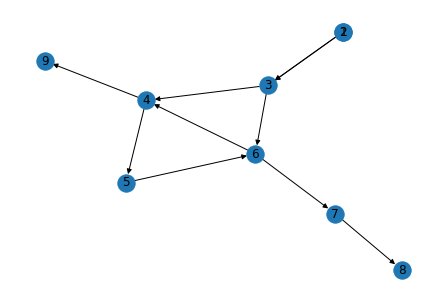

In [ ]:
graph5.tremauxTree.draw_original()

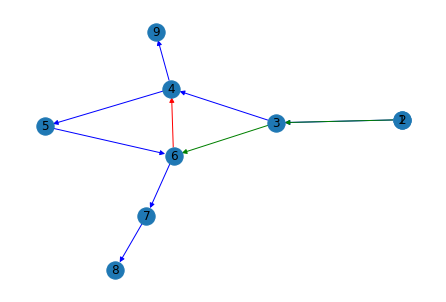

In [ ]:
graph5.tremauxTree.draw()

In [ ]:
graph5.order

[1, 3, 4, 5, 6, 7, 8, 9, 2]

In [ ]:
graph5.toGFA('../../1001G/pantograph/data/shorttest4.gfa',doSeq=False)

## Testing for exporting to Front-end

In [ ]:
pathfileDir = '../../1001G/coreGraph'
coreGFApath = f'{pathfileDir}{os.path.sep}coregraph_v3.gfa'
# coreGFApath = f'{pathfileDir}{os.path.sep}coreGraph.gfa'

In [ ]:
gfaFilename = 'AT_Chr1_OGOnly_2.1.gfa'

In [ ]:
# zoomLevels = [1,10,20,100,500,1000,5000,10000,50000,100000,500000,1000000]
zoomLevels = [1,3,9,45,90,450,900,4500,9000]
# zoomLevels = [1,3,9,18]
# zoomLevels = [4,8,16,32]
maxLengthComponent = 100
maxLengthChunk = 6
invertionThreshold = 0.5
# inputPath = '../../1001G/pantograph/data/shorttest2.gfa'
# inputPath = '../../1001G/pantograph/data/AT_Chr1_OGOnly.gfa'
# inputPath = '../../1001G/chrisGraph/chr1.wfmash.n20.a90.s10000.p1,19,39,3,81,1.seqwish.sort.smooth.sort.gfa'
# inputPath = '../../1001G/pantograph/data/shorttest_seq.gfa'
inputPath = f'{gfadir}{os.path.sep}{gfaFilename}'


In [ ]:
zoomLevels = adjustZoomLevels(zoomLevels)
outputPath,outputName = pathConvert(inputPath,suffix='_new')
outputPath,outputName,zoomLevels

('../../1001G/pantograph/data',
 'AT_Chr1_OGOnly_2.1_new',
 [1, 3, 9, 45, 90, 450, 900, 4500, 9000])

In [ ]:
dbid = getDBID('../pantograph_API/data/caseToDBID.dict',outputName)
print(f'Opening Redis connection for db {dbid}')
redisConn = Redis(host='redis',port = 6379,db=dbid)

Opening Redis connection for db 1


In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_init.ipynb.
Converted 01_graph.ipynb.
Converted 02_tree.ipynb.
Converted 03_synteny.ipynb.
Converted 04_utils.ipynb.
Converted 05_export.ipynb.
Converted deBruijnGraphProcessing.ipynb.
Converted graphTesting.ipynb.
Converted index.ipynb.


In [ ]:
# zoomComponentLengths,zoomNodeToComponent,zoomComponentToNodes,zoomComponents,zoomCompNucleotides,toLinks,fromLinks,graph = \
exportToPantograph(inputPath=inputPath,
                   outputName=outputName,
                   outputPath=outputPath,
                   isSeq=False,
                   redisConn=redisConn,
                   GenomeGraphParams={'accessionsToRemove':['Consensus']},
                   zoomLevels=zoomLevels,
                   maxLengthChunk=maxLengthChunk,
                   maxLengthComponent=maxLengthComponent,
                   invertionThreshold=invertionThreshold,)
#                    debug=True,returnDebugData=True)

Loading Genome
Loading graph from ../../1001G/pantograph/data/AT_Chr1_OGOnly_2.1.gfa
Found node annotation file ../../1001G/pantograph/data/annotation_AT_Chr1_OGOnly_2.1.dat, loading associations.
Loading segment 9082/9082
Loading segments finished.
Loading link 16612/16612
Loading links finished
Loading path 28/28
Loading paths finished. 28 paths added, 0 paths ignored.
Calculating nodes length...
Processing node 9082/9082
Finished calculating nodes lengths
Preprocessing paths...
Processing path 28/28
Finished preprocessing paths
Recording Pantograph data to ../../1001G/pantograph/data/AT_Chr1_OGOnly_2.1_new
Calculating nodes length...
Processing node 9082/9082
Finished calculating nodes lengths
Preprocessing paths...
Processing path 28/28
Finished preprocessing paths

Zoom level 1
Processing node 1640/9082

In [ ]:
!ntfy send "Exporting gene graph finished!"

### Comments

Each node processing time increase significantly with overall number of nodes. This is wrong and should be investigated.

# Adding nucleotide data

In [ ]:
from copy import deepcopy
import numpy as np

In [ ]:
coregraph = GenomeGraph(gfaPath=coreGFApath,isGFASeq=False)
coregraph_genes = deepcopy(coregraph)

Loading graph from ../../1001G/coreGraph/coreGraph_v3.gfa
Found node annotation file ../../1001G/coreGraph/annotation_coreGraph_v3.dat, loading associations.
Loading segment 38/38
Loading segments finished.
Loading link 91/91
Loading links finished
Loading path 27/27
Loading paths finished. 27 paths added, 0 paths ignored.
Calculating nodes length...
Processing node 38/38
Finished calculating nodes lengths
Preprocessing paths...
Processing path 27/27
Finished preprocessing paths


In [ ]:
fullGraphPath = '../../1001G/pantograph/data/AT_Chr1_OGOnly_new.gfa'
fullgraph = GenomeGraph(gfaPath=fullGraphPath,isGFASeq=False)

Loading graph from ../../1001G/pantograph/data/AT_Chr1_OGOnly_new.gfa
Loading segment 8087/8087
Loading segments finished.
Loading link 15983/15983
Loading links finished
Loading path 27/27
Loading paths finished. 27 paths added, 0 paths ignored.
Calculating nodes length...
Processing node 8087/8087
Finished calculating nodes lengths
Preprocessing paths...
Processing path 27/27
Finished preprocessing paths


In [ ]:
chainToGenesFile = 'chain2gene_v3.txt'
maxChainLength = len(coregraph.nodes[0])
chainToListDict = {}
with open(f'{pathfileDir}{os.path.sep}{chainToGenesFile}') as f:
    for line in f:
        chainName, geneList = line.split(':')
        geneList = geneList.lstrip().rstrip().split(',')
        chainToListDict[chainName.zfill(maxChainLength)] = geneList

In [ ]:
for nodeIdx,nodeName in enumerate(coregraph.nodes):
    geneList = chainToListDict.get(nodeName.zfill(maxChainLength), [f'ch{nodeName.zfill(7)}'])
    if geneList[0][:2]!='ch':
        geneList = [fullgraph.nodes[int(gene.rstrip('+'))-1] for gene in geneList]
    coregraph_genes.nodesData[nodeIdx] = ''.join(geneList)
    for accession, chainDict in coregraph.nodesAnnotation[nodeIdx].items():
        interval = chainDict[nodeName]
        geneCumLengths = np.hstack((0, np.cumsum([len(gene) for gene in geneList])))
        coregraph.nodesAnnotation[nodeIdx][accession].update({gene:interval for gene in geneList})
        coregraph_genes.nodesAnnotation[nodeIdx][accession].update({gene:[(geneCumLengths[i], geneCumLengths[i+1]-1)] for i,gene in enumerate(geneList)})
        coregraph_genes.nodesAnnotation[nodeIdx][accession].update({nodeName:[(geneCumLengths[0], geneCumLengths[-1]-1)]})

In [ ]:
pathfileDir

'../../1001G/coreGraph'

In [ ]:
coregraph.toGFA(f'{pathfileDir}{os.path.sep}coregraph_v3.gfa',doSeq=False)
coregraph_genes.toGFA(f'{pathfileDir}{os.path.sep}coregraph_genes_v3.gfa',doSeq=True)

In [ ]:
pathfileDir = '../../1001G/coreGraph'
coreGFApath = f'{pathfileDir}{os.path.sep}coregraph_genes_v3.gfa'
# coreGFApath = f'{pathfileDir}{os.path.sep}coreGraph.gfa'

In [ ]:
# zoomLevels = [1,10,20,100,500,1000,5000,10000,50000,100000,500000,1000000]
zoomLevels = [1,3,9,45,90,450,900,4500,9000]
# zoomLevels = [1,3,9,18]
# zoomLevels = [4,8,16]
maxLengthComponent = 100
maxLengthChunk = 16
invertionThreshold = 0.5
# inputPath = '../../1001G/pantograph/data/shorttest2.gfa'
# inputPath = '../../1001G/pantograph/data/AT_Chr1_OGOnly.gfa'
# inputPath = '../../1001G/chrisGraph/chr1.wfmash.n20.a90.s10000.p1,19,39,3,81,1.seqwish.sort.smooth.sort.gfa'
# inputPath = '../../1001G/pantograph/data/shorttest_seq.gfa'
inputPath = coreGFApath


In [ ]:
zoomLevels = adjustZoomLevels(zoomLevels)
outputPath,outputName = pathConvert(inputPath,suffix='_new')
outputPath,outputName,zoomLevels

('../../1001G/coreGraph',
 'coregraph_genes_v3_new',
 [1, 3, 9, 45, 90, 450, 900, 4500, 9000])

In [ ]:
notebook2script()

Converted 00_init.ipynb.
Converted 01_graph.ipynb.
Converted 02_tree.ipynb.
Converted 03_synteny.ipynb.
Converted 04_utils.ipynb.
Converted 05_export.ipynb.
Converted deBruijnGraphProcessing.ipynb.
Converted index.ipynb.


In [ ]:
dbid = getDBID('../pantograph_API/data/caseToDBID.dict',outputName)
print(f'Opening Redis connection for db {dbid}')
redisConn = Redis(host='redis',port = 6379,db=dbid)

Opening Redis connection for db 2


In [ ]:
# zoomComponentLengths,zoomNodeToComponent,zoomComponentToNodes,zoomComponents,zoomCompNucleotides = \
exportToPantograph(inputPath=inputPath,
                   outputName=outputName,
                   outputPath=outputPath,
                   isSeq=True,
                   redisConn=redisConn,
                   GenomeGraphParams={'accessionsToRemove':['Consensus']},
                   zoomLevels=zoomLevels,
                   maxLengthChunk=maxLengthChunk,
                   maxLengthComponent=maxLengthComponent,
                   invertionThreshold=invertionThreshold,)
#                                              debug=True,returnDebugData=True)

Loading Genome
Loading graph from ../../1001G/coreGraph/coregraph_genes_v3.gfa
Found nodeNames file ../../1001G/coreGraph/nodeNames_coregraph_genes_v3.json, loading names.
Found node annotation file ../../1001G/coreGraph/annotation_coregraph_genes_v3.dat, loading associations.
Loading segment 38/38
Loading segments finished.
Loading link 91/91
Loading links finished
Loading path 27/27
Loading paths finished. 27 paths added, 0 paths ignored.
Calculating nodes length...
Processing node 38/38
Finished calculating nodes lengths
Preprocessing paths...
Processing path 27/27
Finished preprocessing paths
Recording Pantograph data to ../../1001G/coreGraph/coregraph_genes_v3_new
Calculating nodes length...
Processing node 38/38
Finished calculating nodes lengths
Preprocessing paths...
Processing path 27/27
Finished preprocessing paths

Zoom level 1
Processing node 38/38
Nodes processed, recording component to files.
Processing component 370/370
Recording finished. Zoom level time is 1523.9219067

In [ ]:
!ntfy send "Pantograph data generation finished."